# Molybdenum doped Vanadium Dioxide Data

We will be comparing the result of standard punch and fill to that of the technique involving watershed segmentation of the Bragg peaks followed by Laplacian and Matern fill. 

The data can be found on nxrs:
`/data3/GUP-53547/movo2_40/md_54_4b/movo2_40_120K.nxs`

From Matt: the most relevant scattering is found half-integer L planes, with only weak size-effect scattering close to the Bragg peaks; a 3D-deltaPDF should show a clear 2D 'X' pattern.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from   scipy.interpolate import Rbf
from   nexusformat.nexus import *

from skimage.filters import laplace
from skimage.color import label2rgb
from scipy import ndimage as ndi
from skimage import segmentation

from   pathlib import Path
home = str(Path.home())

from skimage import data
from skimage.exposure import histogram

import matplotlib
import matplotlib.gridspec as gridspec
from matplotlib import animation, rc
from IPython.display import HTML

import scipy.signal
from   astropy.convolution import convolve, Kernel, Gaussian1DKernel
import math

# Note: the julia package Laplacians.jl was forked by me and modified. It lives at 
# https://bitbucket.org/clhaley/Laplacians.jl
# If you use the registered package at
# https://github.com/danspielman/Laplacians.jl
# you will get a conflict between the matplotlib plotting software and the julia
# plotting software that is a package dependency, and we don't want that. My package above is identical except that
# it resolves this problem. 
from julia import Julia
julia = Julia(compiled_modules=False)
from julia import Main
julia.eval("@eval Main import Base.MainInclude: include")
julia.include("../../2020_07_Jul/07302020_Meeting/laplacians_julia.jl")

RuntimeError: <PyCall.jlwrap (in a Julia function called from Python)
JULIA: could not open file /Users/vishwasrao/Research/BES_Project/Repo/2020_07_Jul/07302020_Meeting/laplacians_julia.jl
Stacktrace:
 [1] include(::String) at ./client.jl:457
 [2] #invokelatest#1 at ./essentials.jl:710 [inlined]
 [3] invokelatest(::Any, ::Any) at ./essentials.jl:709
 [4] _pyjlwrap_call(::Function, ::Ptr{PyCall.PyObject_struct}, ::Ptr{PyCall.PyObject_struct}) at /Users/vishwasrao/.julia/packages/PyCall/BcTLp/src/callback.jl:28
 [5] pyjlwrap_call(::Ptr{PyCall.PyObject_struct}, ::Ptr{PyCall.PyObject_struct}, ::Ptr{PyCall.PyObject_struct}) at /Users/vishwasrao/.julia/packages/PyCall/BcTLp/src/callback.jl:49>

In [2]:
# Load data, print tree
filename = home+'/Research/BES_Project/Data/movo2_40_120K.nxs'

data = nxload(filename)
data.unlock()

filename_background = home+'/Research/BES_Project/Data/movo2_40_background.nxs'

movo2_40_background = nxload(filename_background)
movo2_40_background.unlock()

#print(data.tree)

/Users/vishwasrao/.julia/conda/3/lib/python3.8/site-packages/nexusformat/nexus/plot.py:237: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gray"))
  im.get_cmap().set_bad('k', 1.0)


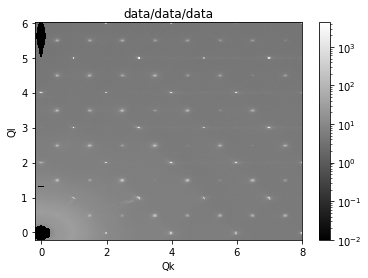

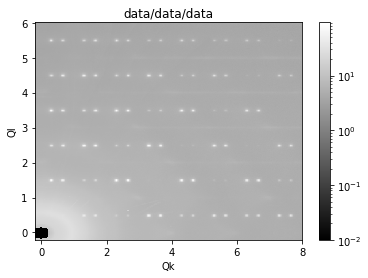

In [3]:
data.entry.symm_transform[-0.2:6.,-0.2:8.,0.0].data.plot(log=True,cmap=plt.cm.gray)
data.entry.symm_transform[-0.2:6.,-0.2:8.,1.0/6].data.plot(log=True, cmap=plt.cm.gray)

In [5]:
# Here we set a "large value" threshold
large_val = 2.65

# Here we set a curvature threshold
upper_curv_thresh = 0.15; lower_curv_thresh = -0.15

def getbraggs(x,dxx):
    return np.nonzero((x-np.rint(x))**2<(dxx/2)**2)[0]

## Look at the distribution of the log values in the dataset

In [6]:
z3d = data.entry.symm_transform[-0.2:6.,-0.2:8.,-0.2:8.].data.nxvalue # - movo2_40_background.entry.symm_transform[-0.2:6.,-0.2:8.,-0.2:8.].data.nxdata
z3dl = np.log(z3d)
# Truncate the logarithm (simpler)
z3dl[z3dl < 0.0] = 0.0

# Take the laplacian of the data
elevation_mapz = laplace(-z3dl)

<ipython-input-6-b8b912eddbe0>:2: RuntimeWarning: divide by zero encountered in log
  z3dl = np.log(z3d)


<ipython-input-7-06bc36e5ee6a>:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(movo2_40_background.entry.symm_transform[-0.2:6.,-0.2:8.,-0.2:8.].data.nxdata[:,:,10]))


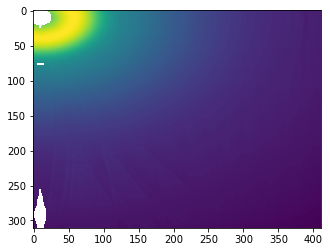

In [7]:
plt.imshow(np.log(movo2_40_background.entry.symm_transform[-0.2:6.,-0.2:8.,-0.2:8.].data.nxdata[:,:,10]))

(-0.5, 410.5, -0.5, 310.5)

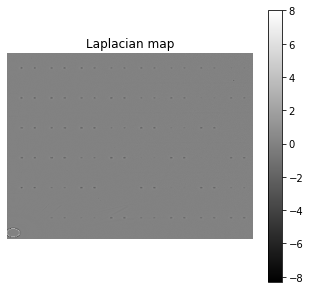

In [8]:
fig, ax = plt.subplots(figsize=(5.5, 5))
c = ax.imshow(elevation_mapz[:,:,20], cmap=plt.cm.gray, origin='lower')
fig.colorbar(c, ax=ax)
ax.set_title('Laplacian map')
ax.axis('off')

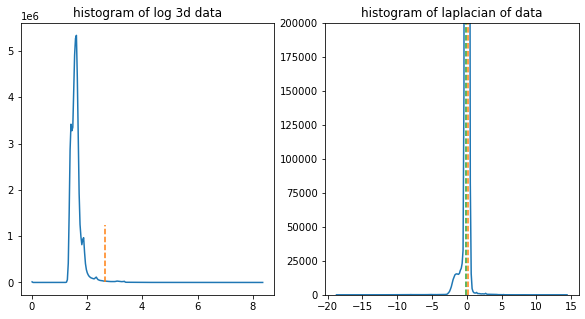

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))

hisst, hisst_centers = histogram(z3dl)
axes[0].plot(hisst_centers, hisst)
axes[0].plot([large_val,large_val],[-5,1.25e6],linestyle="dashed")
axes[0].set_title("histogram of log 3d data");

hist, hist_centers = histogram(elevation_mapz)
axes[1].plot(hist_centers, hist)
axes[1].plot([upper_curv_thresh,upper_curv_thresh],[0,2e5],linestyle="dashed")
axes[1].plot([lower_curv_thresh,lower_curv_thresh],[0,2e5],linestyle="dashed")
axes[1].set_ylim([0,2e5])
axes[1].set_title("histogram of laplacian of data");

## Watershed segmentation

In [44]:
# The markers should be the Bragg locations
x = data.entry.symm_transform[-0.2:6.,-0.2:8.,-0.2:8.].Ql.nxvalue
x2 = data.entry.symm_transform[-0.2:6.,-0.2:8.,-0.2:8.].Qk.nxvalue
x3 = data.entry.symm_transform[-0.2:6.,-0.2:8.,-0.2:8.].Qh.nxvalue
dx = x[1] - x[0]
dx2 = x2[1] - x2[0]
dx3 = x3[1] - x3[0]
B_locs = getbraggs(x,dx)
B_locs2 = getbraggs(x2,dx2)
B_locs3 = getbraggs(x3,dx3)

# Mark as background (0) all values by default, 
# those with high curvature get the marker 1 and 
# the Bragg locations get marked with 2
markerz = np.zeros_like(z3dl)
markerz[(elevation_mapz <= upper_curv_thresh)*(lower_curv_thresh <= elevation_mapz)] = 1
markerz[z3dl > large_val] = 0
for i in B_locs:
    for j in B_locs2:
        for k in B_locs3:
            markerz[i,j,k] = 2
            
dx,dx2,dx3

(0.020000000000000462, 0.019999999999999574, 0.019999999999999574)

(-0.5, 410.5, -0.5, 310.5)

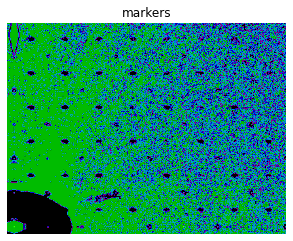

In [11]:
# This is the zero plane in l
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(markerz[:,:,10], cmap=plt.cm.nipy_spectral, origin='lower')
ax.set_title('markers')
ax.axis('off')

## Do the segmentation part

In [12]:
segmentation_z3d = segmentation.watershed(elevation_mapz, markerz)
segmentation_z23d = ndi.binary_fill_holes(segmentation_z3d-1)
labeled_z, _ = ndi.label(segmentation_z23d)

(-0.5, 410.5, -0.5, 310.5)

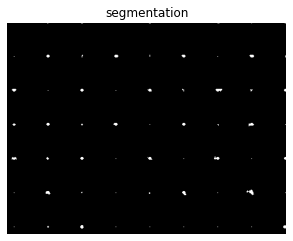

In [13]:
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(segmentation_z3d[:,:,10], cmap=plt.cm.gray, origin='lower')
ax.set_title('segmentation')
ax.axis('off')

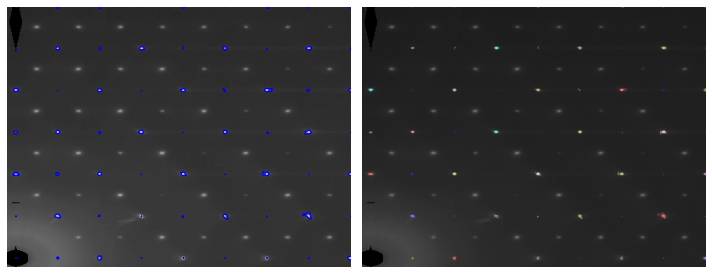

In [15]:
m = np.max(z3dl[:,:,10])
image_label_overlayz3d = label2rgb(labeled_z[:,:,10], image=(z3dl[:,:,10]/m), bg_label=0)

fig, axes = plt.subplots(1, 2, figsize=(10,6), sharey=True)
axes[0].imshow(z3dl[:,:,10]/m, cmap=plt.cm.gray, origin='lower') #, extent = [-0.2, 6, -0.2, 8.])
axes[0].contour(segmentation_z23d[:,:,10], [0.5], linewidths=1.2, colors='b')
axes[1].imshow(image_label_overlayz3d, origin='lower')

for a in axes:
    a.axis('off')

plt.tight_layout()

plt.show()

## Define the symmetrizing operation and the standard punch

In [16]:
Qh_lim=8
Qk_lim=8
Ql_lim=6

kmin=50*(6-Ql_lim)
kmax=50*(6+Ql_lim)
jmin=50*(8-Qk_lim)
jmax=50*(8+Qk_lim)
imin=50*(8-Qh_lim)
imax=50*(8+Qh_lim)
def flipaxis(A,i):
    Aprime=np.swapaxes(np.swapaxes(A,0,i)[::-1],0,i)
    return Aprime

def symmetrize(res):
    # Convolultion happens over a single octant of the dataset
    # This is a bit ad-hoc as the indices are hard-coded.
    vvals=np.zeros((601,801,801))
    vvals[290:601,390:801,390:801] = res
    vvals[300:601,400:801,0:401] = flipaxis(vvals[300:601,400:801,400:801],2)
    vvals[300:601,0:401,0:801] = flipaxis(vvals[300:601,400:801,0:801],1)
    vvals[0:301,0:801,0:801] = flipaxis(vvals[300:601,0:801,0:801],0)
    # background subtraction - what is the minimum spherically symmetric background - not
    # rigorously based on anything
    # vvals=vvals[kmin:kmax,jmin:jmax,imin:imax]-movo2_40_background.entry.symm_transform[-6.:5.98,-8.:7.98,-8.:7.98].data.nxdata-2
    # Anything less than zero is set to zero. No intensity should be less than zero
    # vvals[vvals < 0] = 0
    return vvals[0:600,0:800,0:800]

In [17]:
def standard_punch(x,x2,x3,z3d,rad):
    L,K,H = np.meshgrid(x,x2,x3,indexing='ij')
    print(L.shape)
    punch_locs = np.where(((L-np.rint(L))**2/(1.**2)+(K-np.rint(K))**2/(1.5**2)+(H-np.rint(H))**2/(1.5**2))<(rad)**2,np.nan*np.ones(np.shape(z3d)),np.ones(np.shape(z3d)))
    # Perform the punch
    print(np.shape(punch_locs))
    punched   = np.multiply(z3d, punch_locs)
    nan_locs  = np.where(np.isnan(punched)==1,np.ones(np.shape(z3d)),np.zeros(np.shape(z3d)))
    return punched, nan_locs

In [29]:
julia.include("/Users/vishwasrao/Research/BES_Project/Repo/laplaceinterpolation/MaternKernelApproximation.jl")

<PyCall.jlwrap Laplace3D_Grid>

In [30]:
epsilon = 0.
radius = 0.2001;
h = 0.02;
z3dtemp = z3d[40:81,40:81,40:81];
xtemp = x[40:81];
x2temp = x[40:81];
x3temp = x[40:81];
%time restored_img, punched_image = julia.Laplace3D_Grid(xtemp, x2temp, x3temp, z3dtemp, epsilon, radius, h)

CPU times: user 645 ms, sys: 100 ms, total: 746 ms
Wall time: 392 ms


In [53]:
import timeit

In [58]:
xmin = 1
xmax = 6
ymin = 1
ymax = 8
zmin = 1
zmax = 8
xbegin = ybegin = zbegin =-0.2
z3d_copy =np.copy(z3d)
z3d_restored = np.copy(z3d)
stride = 20;
starttime = timeit.default_timer()
for i in range(zmin, zmax):
    i1 = int((i-zbegin) /h)-stride
    i2 = i1+2*stride+1
    for j in range(ymin, ymax):
        j1 = int((j-ybegin)/h)-stride;
        j2 = j1+2*stride+1
        for k in range(xmin, xmax):
            k1 = int((k-ybegin)/h) - stride
            k2 = k1+2*stride+1
            z3temp = z3d_copy[k1:k2,j1:j2,i1:i2]
            restored_img, punched_image = julia.Laplace3D_Grid(x[k1:k2], x2[j1:j2], x3[i1:i2], z3dtemp, epsilon, radius, h)
            restored_img_reshape = np.reshape(restored_img, (2*stride+1,2*stride+1,2*stride+1))
            z3d_restored[k1:k2, j1:j2, i1:i2] = restored_img_reshape.T
print("Time taken :", timeit.default_timer() - starttime)

Time taken : 42.72218401400096


In [35]:
restored_img_reshape = np.reshape(restored_img, (41,41,41))
z3d_copy = np.copy(z3d);
z3d_copy[40:81,40:81,40:81] = restored_img_reshape.T;

(0.0, 2323.029052734375)

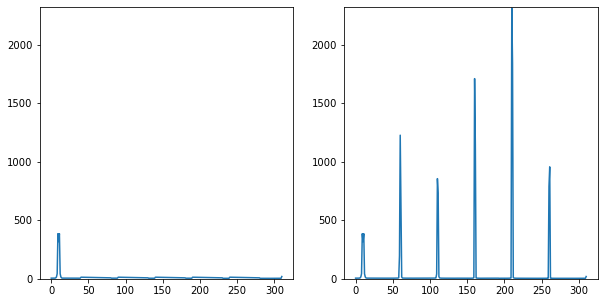

In [59]:
#plt.imshow(restored_img_reshaped[410,410,:].T)
#plt.imshow(z3d[:,:,410])
idx = 210;
idy = 210;
max1 = np.max(z3d_copy[:,idy,idx])
max2 = np.max(z3d[:,idy,idx])
max_y = np.max([max1, max2])+10
fig,ax=plt.subplots(1,2, figsize=(10,5))
ax[0].plot(z3d_restored[:, idy,idx])
ax[0].set_ylim([0, max_y])
ax[1].plot(z3d[:,idy, idx])
ax[1].set_ylim([0, max_y])

In [ ]:
# Here are the standard punch locations
epsilon = 0.
radius = 0.2001;
h = 0.02;

#For Matern interpolation call julia.Matern3D_Grid with same arguments.
%time restored_img, punched_image = julia.Laplace3D_Grid(x, x2, x3, z3d, epsilon, radius, h)
#Punch step
# print((np.max(x3)))
#punched, nan_locs = standard_punch(x,x2,x3,z3d,0.2001)

# This punch radius is huge...
#punch_locs=np.where(((L-np.rint(L))**2/(1.**2)+(K-np.rint(K))**2/(1.5**2)+(H-np.rint(H))**2/(1.5**2))<(0.2001)**2,np.nan*np.ones((601,801,801)),np.ones((601,801,801)))

In [46]:
restored_img_reshaped = np.reshape(restored_img, (411,411, 311))
print(restored_img_reshaped[1,0,0])
print(z3d[0,0,1])
#plt.imshow(restored_img_reshaped[410,410,:].T)
#plt.imshow(z3d[:,:,410])
idx = 210;
idy = 110;
max1 = np.max(restored_img_reshaped[:,idy,idx])
max2 = np.max(z3d[idx,idy,:])
max_y = np.max([max1, max2]) +10
fig,ax=plt.subplots(1,2, figsize=(10,5))
ax[0].plot(restored_img_reshaped[idx,idy,:])
ax[0].set_ylim([0, max_y])
ax[1].plot(z3d[:,idy, idx])
ax[1].set_ylim([0, max_y])

ValueError: cannot reshape array of size 68921 into shape (411,411,311)

## Run a little sanity check on the watershed punch locations and then save them

In [22]:
punched, nan_locs = standard_punch(x,x2,x3,z3d,0.2001)

(311, 411, 411)
(311, 411, 411)


In [23]:
# Compute the watershed punch locations
new_nan_locs = np.where(segmentation_z23d,np.nan*np.ones(np.shape(z3d)),np.ones(np.shape(z3d)))
new_punch_locs = np.where(segmentation_z23d,np.ones(np.shape(z3d)),np.zeros(np.shape(z3d)))
new_punch_locs.shape

(311, 411, 411)

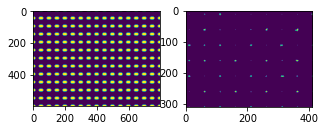

In [24]:
# Plot the standard punch locations vs the watershed ones
fig,ax=plt.subplots(1,2, figsize=(5,5))
ax[0].imshow(symmetrize(nan_locs)[:,:,401])
ax[1].imshow(new_punch_locs[:,:,10])

In [25]:
symmetrize(nan_locs).shape

(600, 800, 800)

## Save the watershed and standard punch locations to an .nxs file 

In [26]:
from pathlib import Path
home = str(Path.home())

# These are the axes
expt_data = nxload(home+'/Research/BES_Project/Data/movo2_40_120K.nxs')['entry'] # or root['entry/masked_transform']

In [27]:
# Save the standard punch locations
root = NXroot(NXentry())
# Make a nexus field for the Standard punch 
stdpunch = NXfield(symmetrize(nan_locs), name='standard_punch_locs')
root.entry.sphere_punch = NXdata(stdpunch, expt_data.symm_transform[-6.:5.98,-8.:7.98,-8.:7.98].nxaxes)

root.save(home+'/Research/BES_Project/Data/punched/movo2_40_sphere_punch_locs.nxs')

NeXusError: '/Users/vishwasrao/Research/BES_Project/Data/punched/movo2_40_sphere_punch_locs.nxs' cannot be opened by h5py

In [28]:
# Save the watershed punch locations
root = NXroot(NXentry())
# Make a nexus field for the Standard punch 
wspunch = NXfield(symmetrize(new_punch_locs), name='watershed_punch_locs')
root.entry.watershed_punch = NXdata(wspunch, expt_data.symm_transform[-6.:5.98,-8.:7.98,-8.:7.98].nxaxes)

root.save(home+'/Research/BES_Project/Data/punched/movo2_40_watershed_punch_locs.nxs')

NeXusError: '/Users/vishwasrao/Research/BES_Project/Data/punched/movo2_40_watershed_punch_locs.nxs' cannot be opened by h5py

# Interpolation step

In [29]:
def _round_up_to_odd_integer(value):
    i = int(math.ceil(value))
    if i % 2 == 0:
        return i + 1
    else:
        return i

    
class Gaussian3DKernel(Kernel):

    _separable = True
    _is_bool = False

    def __init__(self, stddev, **kwargs):
        x = np.linspace(-15., 15., 17)
        y = np.linspace(-15., 15., 17)
        z = np.linspace(-15., 15., 17)
        X,Y,Z = np.meshgrid(x,y,z)
        array = np.exp(-(X**2+Y**2+Z**2)/(2*stddev**2))
        self._default_size = _round_up_to_odd_integer(8 * stddev)
        super(Gaussian3DKernel, self).__init__(array)
        self.normalize()
        self._truncation = np.abs(1. - self._array.sum())

gkernal = Gaussian3DKernel(2)

def standard_fill(z3d, punched, nan_locs):
    vvals = convolve(punched,gkernal)
    res   = z3d*(1-nan_locs)+vvals*nan_locs
    return res

In [30]:
# Conventional punch and Gaussian fill
%time res = standard_fill(z3d,punched,nan_locs)

CPU times: user 10min 41s, sys: 2.11 s, total: 10min 43s
Wall time: 33min 18s


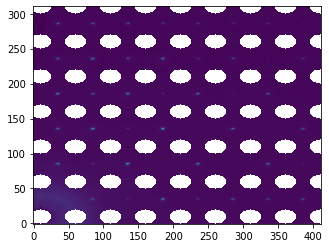

In [34]:
# plt.imshow(res[:,:,10], origin='lower')
plt.imshow(punched[:,:,10], origin='lower')

In [ ]:
# Save the standard punch and fill result
root = NXroot(NXentry())
stdinterp = NXfield(symmetrize(res), name='sphere_punch_gauss_interp_data')
root.entry.sphere_gauss_data = NXdata(stdinterp, expt_data.symm_transform[-6.:5.98,-8.:7.98,-8.:7.98].nxaxes)

root.save('aux/movo2_40_sphere_gauss_data.nxs')

In [35]:
# Compute the interpolation with the watershed punch and Gaussian fill: 
%time res_newpunch = standard_fill(z3d, np.where(new_punch_locs,np.nan*np.ones(np.shape(z3d)),z3d), new_punch_locs)

CPU times: user 4min 23s, sys: 210 ms, total: 4min 23s
Wall time: 4min 20s


In [ ]:
plt.imshow(np.log(res_newpunch[:,:,10]), origin='lower')
#plt.imshow(np.where(new_punch_locs[:,:,10],np.nan*np.ones(np.shape(z3dl[:,:,10])),z3dl[:,:,10]), origin='lower')
#plt.imshow(new_punch_locs[:,:,10], origin='lower')
#plt.imshow(np.multiply(z3d, new_punch_locs)[:,:,10],origin='lower')

#np.sum(new_punch_locs[:,:,10])

In [36]:
# Save the watershed punch and Gaussian fill
root = NXroot(NXentry())
watergaussinterp = NXfield(symmetrize(res_newpunch), name='watershed_punch_gauss_interp_data')
root.entry.watershed_gauss_data = NXdata(watergaussinterp, expt_data.symm_transform[-6.:5.98,-8.:7.98,-8.:7.98].nxaxes)
root.save('aux/movo2_40_watershed_gauss_data.nxs')

NeXusError: '/Users/charlottehaley/Documents/Crystallography/2020_08_Aug/08062020_Meeting/aux/movo2_40_watershed_gauss_data.nxs' cannot be opened by h5py

In [37]:
# Function that wraps the julia code for the laplacian interpolation
def laplacian_fill(z3d, new_punch_locs):
    res = julia.laplacians_julia(z3d.shape, np.where(new_punch_locs.flatten()==0)[0], z3d[new_punch_locs==0].flatten())
    return z3d*(1-new_punch_locs)+res*new_punch_locs

In [38]:
# Compute the interpolation with the watershed punch and Laplacian fill: 
%time res_laplace = laplacian_fill(z3d, new_punch_locs)

CPU times: user 25.9 s, sys: 17.7 s, total: 43.6 s
Wall time: 44.6 s


/Users/charlottehaley/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


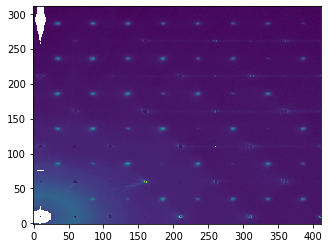

In [47]:
#fig,ax=plt.subplots(1,2, figsize=(5,5))
#ax[0].imshow(res_newpunch[:,:,10], origin='lower')
#ax[1]
plt.imshow(np.log(res_laplace[:,:,10]), origin='lower')

#res_newpunch[:,:,10], res_laplace[:,:,10]

In [ ]:
# Save the watershed punch and Laplacian fill
root = NXroot(NXentry())
lapintwpunch = NXfield(symmetrize(res_laplace), name='laplace_interp_watershed_punch')
# Pack these under root
root.entry.watershed_laplace_data = NXdata(lapintwpunch, expt_data.symm_transform[-6.:5.98,-8.:7.98,-8.:7.98].nxaxes)
root.save('aux/movo2_40_watershed_laplace_data.nxs')

In [39]:
# Compute the interpolation with the sphere punch and Laplacian fill: 
%time sphere_laplace = laplacian_fill(z3d, nan_locs)

CPU times: user 39.1 s, sys: 11.7 s, total: 50.8 s
Wall time: 42 s


/Users/charlottehaley/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


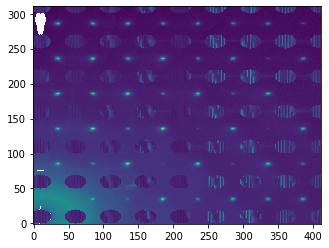

In [48]:
plt.imshow(np.log(sphere_laplace[:,:,10]), origin='lower')

In [ ]:
# Save the sphere punch and Laplacian fill
root = NXroot(NXentry())
lapintroundpunch = NXfield(symmetrize(sphere_laplace), name='laplace_interp_sphere_punch')
root.entry.sphere_laplace_data = NXdata(lapintroundpunch, expt_data.symm_transform[-6.:5.98,-8.:7.98,-8.:7.98].nxaxes)
root.save('aux/movo2_40_sphere_laplace_data.nxs')

In [40]:
# Function that wraps the julia code for the matern interpolation
def matern_fill(z3d, new_p, epsilon, m):
    res = julia.maternDE_julia(z3d.shape, np.where(new_p.flatten()==0)[0], z3d[new_p==0].flatten(), epsilon, m)
    return z3d*(1-new_p)+res*new_p

# Set the parameters
epsilon = 0.2
m = 2

In [41]:
%time sphere_matern = matern_fill(z3d, nan_locs, epsilon, m)

CPU times: user 3min 36s, sys: 1min 40s, total: 5min 17s
Wall time: 3min 33s


/Users/charlottehaley/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


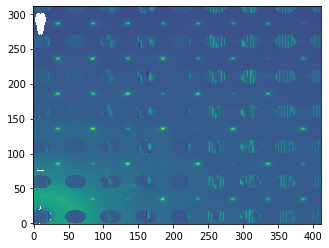

In [51]:
plt.imshow(np.log(sphere_matern[:,:,10]), origin='lower')

In [ ]:
# Save the sphere punch and Matern fill
root = NXroot(NXentry())
matintroundpunch = NXfield(symmetrize(sphere_matern), name='matern_interp_sphere_punch')
root.entry.sphere_matern_data = NXdata(matintroundpunch, expt_data.symm_transform[-6.:5.98,-8.:7.98,-8.:7.98].nxaxes)
root.save('aux/movo2_40_sphere_matern_data.nxs')

In [42]:
%time res_matern = matern_fill(z3d, new_punch_locs, epsilon, m)

CPU times: user 56.1 s, sys: 1min 18s, total: 2min 14s
Wall time: 2min 44s


In [ ]:
# Save the watershed punch and Matern fill
root = NXroot(NXentry())
matintwpunch = NXfield(symmetrize(res_matern), name='matern_interp_watershed_punch')
# Pack these under root
root.entry.watershed_matern_data = NXdata(matintwpunch, expt_data.symm_transform[-6.:5.98,-8.:7.98,-8.:7.98].nxaxes)
root.save('aux/movo2_40_watershed_matern_data.nxs')

In [ ]:
# Passes the sanity check
fig,ax=plt.subplots(2,2)
ax[0,0].imshow(res[:,:,10],origin='lower')
ax[0,1].imshow(res_newpunch[:,:,10],origin='lower')
ax[1,0].imshow(res_laplace[:,:,10],origin='lower')
ax[1,1].imshow(sphere_laplace[:,:,10],origin='lower')

## In summary: times

|Algorithm | Time |
|:---|:---|
| Standard punch and fill | CPU times: user 4min 44s, sys: 880 ms, total: 4min 44s |
| | Wall time: 4min 43s |
| Watershed punch and standard fill| CPU times: user 4min 44s, sys: 1.16 s, total: 4min 45s |
| | Wall time: 4min 44s |
|laplacian w watershed punch | CPU times: user 22.2 s, sys: 15.4 s, total: 37.6 s
| | Wall time: 33.9 s |
|laplacian w standard punch | CPU times: user 43 s, sys: 14 s, total: 57 s |
| | Wall time: 46.9 s |
| Matern (m=2) w watershed punch | CPU times: user 53.8 s, sys: 1min 10s, total: 2min 4s |
| | Wall time: 2min 20s |
| Matern (m = 2) w standard punch | CPU times: user 3min 25s, sys: 1min 45s, total: 5min 10s |
| | Wall time: 3min 20s |

(Note that interpolation times are being reported here, time to compute the punch locations is not included.)


# Fourier transform

In [43]:
#################################################	

window=np.tile(scipy.signal.tukey(jmax-jmin)[None,:,None],((kmax-kmin),1,(imax-imin)))*np.tile(scipy.signal.tukey(kmax-kmin)[:,None,None],(1,(jmax-jmin),(imax-imin)))*np.tile(scipy.signal.tukey(imax-imin)[None,None,:],((kmax-kmin),(jmax-jmin),1))

ksteps=kmax-kmin
jsteps=jmax-jmin
isteps=imax-imin

xvals=np.linspace(-25,25-50./isteps,isteps)
yvals=np.linspace(-25,25-50./jsteps,jsteps)
zvals=np.linspace(-25,25-50./ksteps,ksteps)

xfield=NXfield(xvals,name='x')
yfield=NXfield(yvals,name='y')
zfield=NXfield(zvals,name='z')

####################################

def symmetrize_computefft(res, namestr = 'fft'):
    # Convolultion happens over a single octant of the dataset
    # This is a bit ad-hoc as the indices are hard-coded.
    vvals=np.zeros((601,801,801))
    vvals[290:601,390:801,390:801] = res
    vvals[300:601,400:801,0:401] = flipaxis(vvals[300:601,400:801,400:801],2)
    vvals[300:601,0:401,0:801] = flipaxis(vvals[300:601,400:801,0:801],1)
    vvals[0:301,0:801,0:801] = flipaxis(vvals[300:601,0:801,0:801],0)
    # background subtraction - what is the minimum spherically symmetric background 
    vvals=vvals[kmin:kmax,jmin:jmax,imin:imax]-movo2_40_background.entry.symm_transform[-6.:5.98,-8.:7.98,-8.:7.98].data.nxdata-2
    # Anything less than zero is set to zero. No intensity should be less than zero
    vvals[vvals < 0] = 0
    fourier = np.fft.fftshift(np.fft.fftn(np.fft.fftshift((vvals*window))))
    fourier_field = NXfield(np.real(fourier), name=namestr)
    return fourier_field


In [ ]:
# Save the sphere_gauss fft
root = NXroot(NXentry())
root.entry.sphere_gauss_fft = NXdata(symmetrize_computefft(res,"sphere_gauss_fft"),[zfield,yfield,xfield])
root.save('aux/movo2_40_sphere_gauss_fft.nxs')

In [ ]:
# Save the sphere_laplace fft
root = NXroot(NXentry())
root.entry.sphere_laplace_fft  = NXdata(symmetrize_computefft(sphere_laplace,"sphere_laplace_fft"),[zfield,yfield,xfield])
root.save('aux/movo2_40_sphere_laplace_fft.nxs')

In [ ]:
# Save the sphere_matern fft
root=NXroot(NXentry())
root.entry.sphere_matern_fft  = NXdata(symmetrize_computefft(sphere_matern,"sphere_matern_fft"),[zfield,yfield,xfield])
root.save('aux/movo2_40_sphere_matern_fft.nxs')

In [ ]:
# Save the watershed_gauss fft
root = NXroot(NXentry())
root.entry.watershed_gauss_fft  = NXdata(symmetrize_computefft(res_newpunch,"watershed_gauss_fft"),[zfield,yfield,xfield])
root.save('aux/movo2_40_watershed_gauss_fft.nxs')

In [44]:
# Save the watershed_laplace fft
root = NXroot(NXentry())
root.entry.watershed_laplace_fft  = NXdata(symmetrize_computefft(res_laplace,"watershed_laplace_fft"),[zfield,yfield,xfield])
root.save('aux/movo2_40_watershed_laplace_fft.nxs')

NXroot('root')

In [45]:
# Save the watershed_matern fft
root=NXroot(NXentry())
root.entry.watershed_matern_fft  = NXdata(symmetrize_computefft(res_matern,"watershed_matern_fft"),[zfield,yfield,xfield])
root.save('aux/movo2_40_watershed_matern_fft.nxs')

NXroot('root')

In [ ]:
# Now make a master file with links to the appropriate .nxs files

root = NXroot(NXentry())
ent_sl = NXlink(target='/entry/sphere_punch/standard_punch_locs', file='aux/movo2_40_sphere_punch_locs.nxs')
root.entry.sphere_locs = NXdata(ent_sl, expt_data.symm_transform[-6.:5.98,-8.:7.98,-8.:7.98].nxaxes)
ent_wl = NXlink(target='/entry/watershed_punch/watershed_punch_locs', file='aux/movo2_40_watershed_punch_locs.nxs')
root.entry.watershed_locs = NXdata(ent_wl, expt_data.symm_transform[-6.:5.98,-8.:7.98,-8.:7.98].nxaxes)
#
ent_sgd = NXlink(target='/entry/sphere_gauss_data/sphere_punch_gauss_interp_data', file='aux/movo2_40_sphere_gauss_data.nxs')
root.entry.sphere_gauss_data = NXdata(ent_sgd, expt_data.symm_transform[-6.:5.98,-8.:7.98,-8.:7.98].nxaxes)
ent_sld = NXlink(target='/entry/sphere_laplace_data/laplace_interp_sphere_punch', file='aux/movo2_40_sphere_laplace_data.nxs')
root.entry.sphere_laplace_data = NXdata(ent_sld, expt_data.symm_transform[-6.:5.98,-8.:7.98,-8.:7.98].nxaxes)
ent_smd = NXlink(target='/entry/sphere_matern_data/matern_interp_sphere_punch', file='aux/movo2_40_sphere_matern_data.nxs')
root.entry.sphere_matern_data = NXdata(ent_smd, expt_data.symm_transform[-6.:5.98,-8.:7.98,-8.:7.98].nxaxes)
#
ent_sgf = NXlink(target='/entry/sphere_gauss_fft/sphere_gauss_fft', file='aux/movo2_40_sphere_gauss_fft.nxs')
root.entry.sphere_gauss_fft = NXdata(ent_sgf, [zfield,yfield,xfield])
ent_slf = NXlink(target='/entry/sphere_laplace_fft/sphere_laplace_fft', file='aux/movo2_40_sphere_laplace_fft.nxs')
root.entry.watershed_laplace_fft = NXdata(ent_slf, [zfield,yfield,xfield])
ent_smf = NXlink(target='/entry/sphere_matern_fft/sphere_matern_fft', file='aux/movo2_40_sphere_matern_fft.nxs')
root.entry.sphere_matern_fft = NXdata(ent_smf, [zfield,yfield,xfield])
#
ent_wgd = NXlink(target='/entry/watershed_gauss_data/watershed_punch_gauss_interp_data', file='aux/movo2_40_watershed_gauss_data.nxs')
root.entry.watershed_gauss_data = NXdata(ent_wgd, expt_data.symm_transform[-6.:5.98,-8.:7.98,-8.:7.98].nxaxes)
ent_wld = NXlink(target='/entry/watershed_laplace_data/laplace_interp_watershed_punch', file='aux/movo2_40_watershed_laplace_data.nxs')
root.entry.watershed_laplace_data = NXdata(ent_wld, expt_data.symm_transform[-6.:5.98,-8.:7.98,-8.:7.98].nxaxes)
ent_wmd = NXlink(target='/entry/watershed_matern_data/matern_interp_watershed_punch', file='aux/movo2_40_watershed_matern_data.nxs')
root.entry.watershed_matern_data = NXdata(ent_wmd, expt_data.symm_transform[-6.:5.98,-8.:7.98,-8.:7.98].nxaxes)
#
ent_wgf = NXlink(target='/entry/watershed_gauss_fft/watershed_gauss_fft', file='aux/movo2_40_watershed_gauss_fft.nxs')
root.entry.watershed_gauss_fft = NXdata(ent_wgf, [zfield,yfield,xfield])
ent_wlf = NXlink(target='/entry/watershed_laplace_fft/watershed_laplace_fft', file='aux/movo2_40_watershed_laplace_fft.nxs')
root.entry.watershed_laplace_fft = NXdata(ent_wlf, [zfield,yfield,xfield])
ent_wmf = NXlink(target='/entry/watershed_matern_fft/watershed_matern_fft', file='aux/movo2_40_watershed_matern_fft.nxs')
root.entry.watershed_matern_fft = NXdata(ent_wmf, [zfield,yfield,xfield])
#
root.save('movo2_40_master.nxs')

```
L,K,H=np.meshgrid(movo2_40_120K.entry.symm_transform[-6.:6.,-8.:8.,-8.:8.].Ql.nxdata,movo2_40_120K.entry.symm_transform[-6.:6.,-8.:8.,-8.:8.].Qk.nxdata,movo2_40_120K.entry.symm_transform[-6.:6.,-8.:8.,-8.:8.].Qh.nxdata,indexing='ij')

punch_locs=np.where(((L-np.rint(L))**2/(1.**2)+(K-np.rint(K))**2/(1.5**2)+(H-np.rint(H))**2/(1.5**2))<(0.2001)**2,np.nan*np.ones((601,801,801)),np.ones((601,801,801)))

punch_locs[np.isnan(punch_locs)==0]=1

#######################################################

tvals=np.concatenate((np.arange(30,110,20),np.arange(95,155,5),np.arange(160,190,10),np.arange(200,300,25)),axis=0)

for i in range(0,len(tvals)):
	irinte_fourier(tvals[i])
```

From the original code

```
def movo2_40_fourier(temp):
    directory_name=str(temp)+'K/'
	g=nxtree['movo2_40_'+str(temp)+'K']
	g.unlock()
	fout_name=('fft_movo2_40_'+str(temp)+'K')
	if fout_name in nxtree:
		del nxtree[fout_name]
	nxtree[fout_name]=NXroot()
	nxtree[fout_name]['entry']=NXentry()
	fout=nxtree[fout_name]
	punch_movo2.entry.data.data=g.entry.symm_transform[-6.:6.,-8.:8.,-8.:8.].data*punch_locs
	start=time.time()
	vvals=np.zeros((601,801,801))
	vvals[250:601,350:801,350:801]=convolve(punch_movo2.entry.data[-1.:6.,-1.:8.,-1.:8.].data.nxdata,gkernal)
	vvals[300:601,400:801,0:401]=flipaxis(vvals[300:601,400:801,400:801],2)
	vvals[300:601,0:401,0:801]=flipaxis(vvals[300:601,400:801,0:801],1)
	vvals[0:301,0:801,0:801]=flipaxis(vvals[300:601,0:801,0:801],0)
	interp_movo2.entry.data.data=vvals
	nan_locs=np.where(np.isnan(punch_movo2.entry.data.data.nxdata)==1,np.ones((601,801,801)),np.zeros((601,801,801)))
	non_nan_locs=-1*nan_locs+1
	interp_movo2.entry.data.data=g.entry.symm_transform[-6.:6.,-8.:8.,-8.:8.].data.nxdata*non_nan_locs+interp_movo2.entry.data.data[:,:,:].nxdata*nan_locs
	end=time.time()
	print (end-start)
	fin=interp_movo2
	vvals=fin.entry.data[kmin:kmax,jmin:jmax,imin:imax].data.nxdata-movo2_40_background.entry.symm_transform[-6.:5.98,-8.:7.98,-8.:7.98].data.nxdata-2
	vvals[vvals<0]=0
	fourier=np.fft.fftshift(np.fft.fftn(np.fft.fftshift(vvals*window)))
	fourier_field=NXfield(np.real(fourier),name='fft')
	fout.entry.data=NXdata(fourier_field,[zfield,yfield,xfield])
	nxsave('/data3/GUP-53547/movo2_40/md_54_4b/'+str(temp)+'K/'+fout_name+'.nxs',nxtree[fout_name])
	if 'fft' not in g['entry']:
		g['entry']['fft']=NXdata(NXlink(target='entry/data/fft',file=directory_name+fout_name+'.nxs',name='data'),[zfield,yfield,xfield])
	g.lock()
	print (fout_name+' finished!')
```
